In [1]:
import time

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)  # sometimes this is required to enable logging inside Jupyter

%matplotlib inline
#%precision 2

# Set an arbitrary seed and a global random state to keep the randomly generated quantities the same between runs
seed = 42  # this will be separately given to ELFI
np.random.seed(seed)

In [2]:
def MA2(t_samples, n_obs=100, batch_size=1, random_state=None):
    # Make inputs 2d arrays for numpy broadcasting with w
    t1 = t_samples[:,0]
    t2 = t_samples[:,1]
    t1 = np.asanyarray(t1).reshape((-1, 1))
    t2 = np.asanyarray(t2).reshape((-1, 1))
    random_state = random_state or np.random

    w = random_state.randn(batch_size, n_obs+2)  # i.i.d. sequence ~ N(0,1)
    x = w[:, 2:] + t1*w[:, 1:-1] + t2*w[:, :-2]
    return x

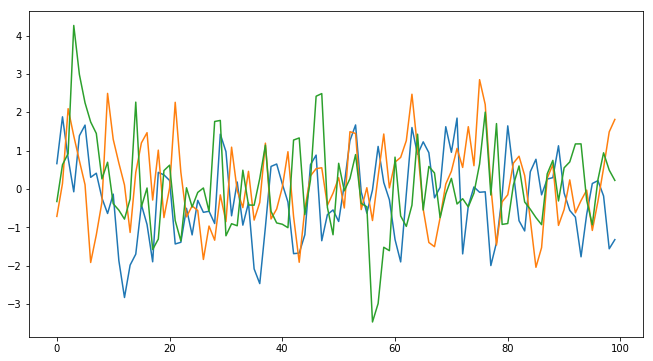

In [3]:
# true parameters
t1_true = 0.6
t2_true = 0.2
t_true = np.array([t1_true, t2_true])[np.newaxis,:]
y_obs = MA2(t_true)

# Plot the observed sequence
plt.figure(figsize=(11, 6));
plt.plot(y_obs.ravel());

# To illustrate the stochasticity, let's plot a couple of more observations with the same true parameters:
plt.plot(MA2(t_true).ravel());
plt.plot(MA2(t_true).ravel());

In [4]:
import elfi

In [5]:
# define prior for t1 as in Marin et al., 2012 with t1 in range [-b, b]
class CustomPrior_t1(elfi.Distribution):
    def rvs(b_bound=2, a_bound=1, size=(1,), random_state=None):
        #import ipdb; ipdb.set_trace()
        if not isinstance(size, tuple):
            size = (size,)
        size = size + (2,)
        #import ipdb; ipdb.set_trace()
        u_random = scipy.stats.uniform.rvs(loc=0, scale=1, size=size, random_state=random_state)
        u_1 = u_random[:,0]
        u_2 = u_random[:,1]
        t1 = np.where(u_1<0.5, np.sqrt(2.*u_1)*b_bound-b_bound, -np.sqrt(2.*(1.-u_1))*b_bound+b_bound)
        locs = np.maximum(-a_bound-t1, t1-a_bound)
        scales = a_bound - locs
        t2 = u_2*scales+locs 
        return np.vstack((t1,t2)).transpose()        

In [6]:
t1_1000= CustomPrior_t1.rvs(2, 1, size=1000)
#t2_1000 = CustomPrior_t2.rvs(t1_1000, 1, 1000)
print(t1_1000.shape)
t2_100 = scipy.stats.uniform.rvs(0, 2, size=1000)
print (t2_100.shape)

#plt.scatter(t1_1000[0,:], t1_1000[1,:], s=4, edgecolor='none');
# plt.plot([0, 2, -2, 0], [-1, 1, 1, -1], 'b')  # outlines of the triangle

(1000, 2)
(1000,)


In [7]:
# a node is defined by giving a distribution from scipy.stats together with any arguments (here 0 and 2)
t_prior = elfi.Prior(CustomPrior_t1)
#t_prior = elfi.Prior(scipy.stats.uniform, 0, 2, size=2)


# ELFI also supports giving the scipy.stats distributions as strings
#t2 = elfi.Prior('uniform', 0, 2)
Y = elfi.Simulator(MA2, t_prior, observed=y_obs)
def autocov(x, lag=1):
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1)
    return C
S1 = elfi.Summary(autocov, Y)
S2 = elfi.Summary(autocov, Y, 2)  # the optional keyword lag is given the value 2
d = elfi.Distance('euclidean', S1, S2)

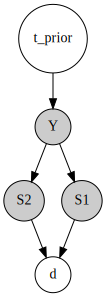

In [8]:
elfi.draw(d)

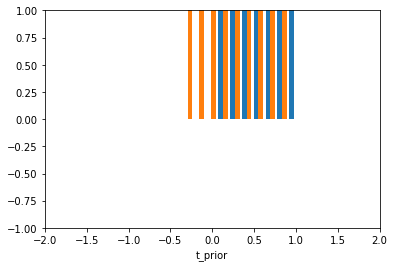

Progress: |██████████████████████████████████████████████████| 100.0% Complete
CPU times: user 51.4 s, sys: 2.43 s, total: 53.8 s
Wall time: 34.5 s


In [12]:
rej = elfi.Rejection(d, batch_size=10000, seed=seed)
N = 1000

vis = dict(xlim=[-2,2], ylim=[-1,1])

# You can give the sample method a `vis` keyword to see an animation how the prior transforms towards the
# posterior with a decreasing threshold.
%time result = rej.sample(N, quantile=0.001, vis=vis)

[0.59 0.14]


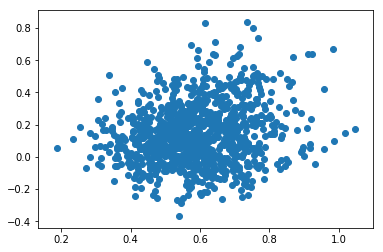

In [13]:
print(result.samples['t_prior'].mean(axis=0))
plt.scatter(result.samples['t_prior'][:,0], result.samples['t_prior'][:,1])

In [14]:
result.summary()

Method: Rejection
Number of samples: 1000
Number of simulations: 1000000
Threshold: 0.0355
